<a href="https://colab.research.google.com/github/kamatamnithin/3.-Predicting-Housing-Market-Trends-with-AI/blob/main/3_Predicting_Housing_Market_Trends_with_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import os

In [2]:
sns.set_style("whitegrid")

In [3]:
!pip install -q kaggle

# Use Colab's file uploader
from google.colab import files
print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
files.upload()

# Create a directory for the Kaggle API configuration
!mkdir -p ~/.kaggle
# Move the uploaded kaggle.json to the required directory
!cp kaggle.json ~/.kaggle/
# Set the correct permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API configured successfully.")

Please upload the kaggle.json file you downloaded from your Kaggle account.


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory

Kaggle API configured successfully.


In [4]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip the downloaded files
!unzip -o house-prices-advanced-regression-techniques.zip

print("\nDataset downloaded and unzipped.")

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open house-prices-advanced-regression-techniques.zip, house-prices-advanced-regression-techniques.zip.zip or house-prices-advanced-regression-techniques.zip.ZIP.

Dataset downloaded and unzipped.


In [6]:
   df=pd.read_csv("train.csv")
   df1=pd.read_csv("test.csv")


In [7]:
df.set_index('Id',inplace=True)
df1.set_index('Id',inplace=True)

In [8]:
df.shape

(1460, 80)

In [9]:
df1.shape

(1459, 79)

In [10]:
print("data loading sucessfully...")
df.head()
df1.head()

data loading sucessfully...


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


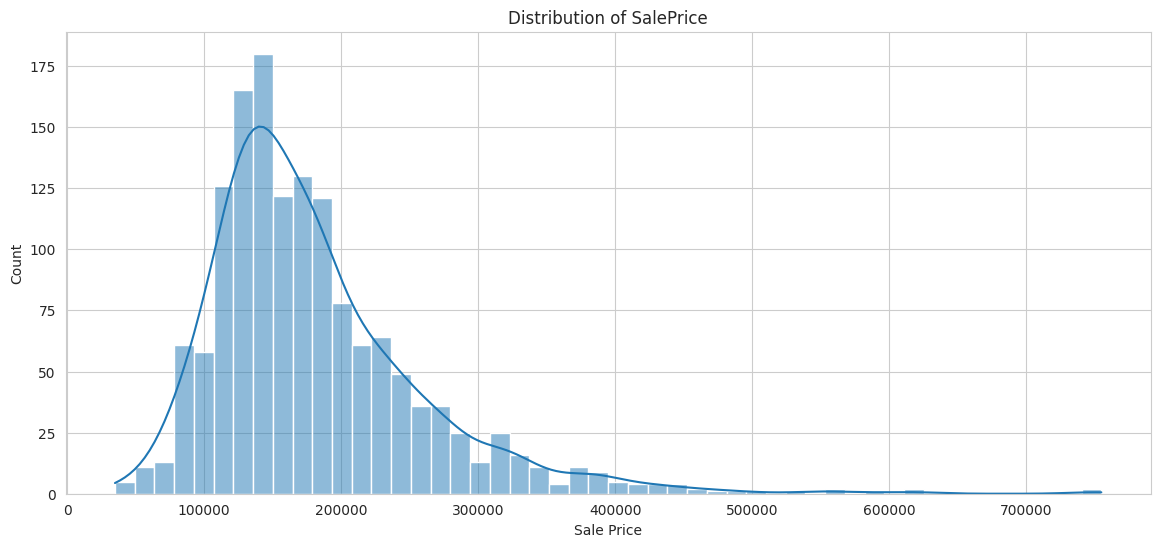

In [11]:
plt.figure(figsize=(14,6))
sns.histplot(df['SalePrice'],kde=True,bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
plt.show()



In [12]:
print(f"Skewness of SalePrice: {df['SalePrice'].skew()}")

Skewness of SalePrice: 1.8828757597682129


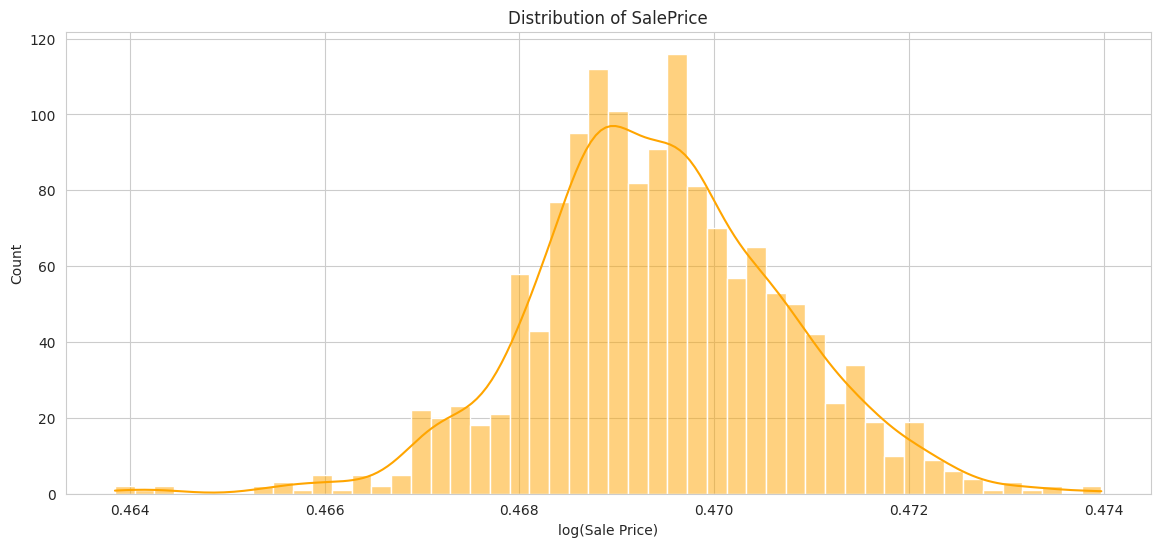

In [21]:
df['SalePrice']=np.log1p(df['SalePrice'])

plt.figure(figsize=(14,6))
sns.histplot(df['SalePrice'],kde=True,bins=50,color='orange')
plt.title('Distribution of SalePrice')
plt.xlabel('log(Sale Price)')
plt.show()

In [22]:
df['SalePrice'].skew()

np.float64(-0.07815410199730469)

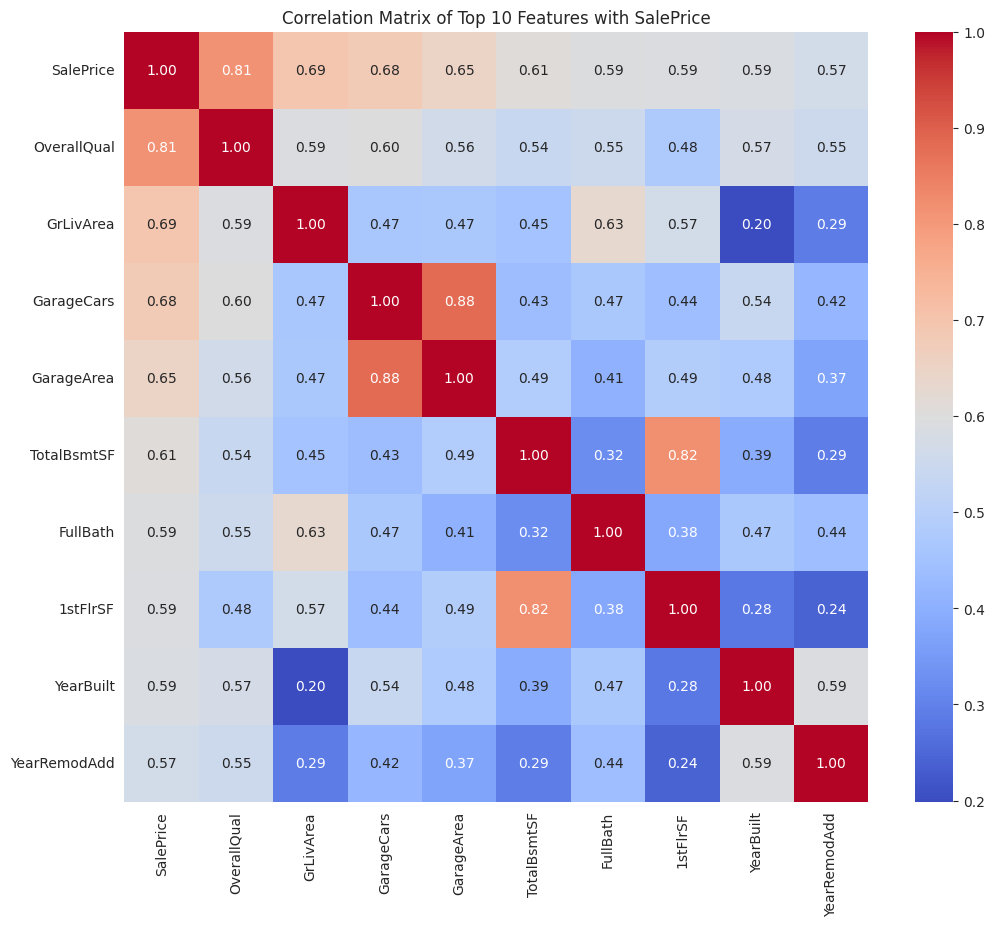

In [23]:
corrmat = df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_matrix = df[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

In [25]:
all_data=pd.concat((df.loc[:,:'SaleCondition'],df1.loc[:,:'SaleCondition']))

In [27]:
print(f"combined data shape:{all_data.shape}")

combined data shape:(2919, 79)


In [28]:
missing_data=all_data.isnull().sum().sort_values(ascending=False)
missing_data=missing_data[missing_data > 0]
print("Feature with missing values:")
print(missing_data)

Feature with missing values:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [29]:
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

In [30]:
all_data[numerical_cols_to_impute_zero].isnull().sum()

,0
MasVnrArea,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
GarageCars,0
GarageArea,0
BsmtFullBath,0
BsmtHalfBath,0


In [31]:
all_data['LotFrontage'].value_counts()

,count
LotFrontage,
60.0,276
80.0,137
70.0,133
50.0,117
75.0,105
...,...
155.0,1
126.0,1
200.0,1


In [32]:
if 'LotFrontage' in all_data.columns and all_data['LotFrontage'].isnull().any():
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [33]:
all_data['Alley'].value_counts()

,count
Alley,
Grvl,120
Pave,78


In [34]:
all_data['Electrical']

,Electrical
Id,
1,SBrkr
2,SBrkr
3,SBrkr
4,SBrkr
5,SBrkr
...,...
2915,SBrkr
2916,SBrkr
2917,SBrkr


In [35]:
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [36]:
if 'GarageYrBlt' in all_data.columns:
    all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", all_data.isnull().sum().sum())


Missing values after all imputation: 0


In [37]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Create a total bathrooms feature
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# Create a feature for age of the house at sale
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']

print("New features created.")

New features created.


In [39]:
all_data['Neighborhood'].value_counts()

,count
Neighborhood,
NAmes,443
CollgCr,267
OldTown,239
Edwards,194
Somerst,182
NridgHt,166
Gilbert,165
Sawyer,151
NWAmes,131


In [41]:
categorical_cols=all_data.select_dtypes(include=['object']).columns
all_data=pd.get_dummies(all_data,columns=categorical_cols,drop_first=True)
print(f"after encoding:{all_data.shape}")

after encoding:(2919, 262)


In [43]:
X=all_data[:len(df)]
y=df['SalePrice']
X_test_final=all_data[len(df):]

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [44]:
print(X_train)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
255           20         70.0     8400            5            6       1957   
1067          60         59.0     7837            6            7       1993   
639           30         67.0     8777            5            7       1910   
800           50         60.0     7200            5            7       1937   
381           50         50.0     5000            5            6       1924   
...          ...          ...      ...          ...          ...        ...   
1096          20         78.0     9317            6            5       2006   
1131          50         65.0     7804            4            3       1928   
1295          20         60.0     8172            5            7       1955   
861           50         55.0     7642            7            8       1918   
1127         120         53.0     3684            7 

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

In [46]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,False,False,True,False,False,False,True,False
2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,False,False,True,False,False,False,True,False
4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,False,False,True,False,False,False,False,False
5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
1457,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,...,False,False,False,False,True,False,False,False,True,False
1458,70,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,...,False,False,False,False,True,False,False,False,True,False


In [47]:
lr=LinearRegression()
lr.fit(X_train_scaled,y_train)
y_pred_lr=lr.predict(X_val_scaled)

In [48]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

# XGBoost can handle NaNs, but since we've cleaned the data, we can use the scaled data as well if preferred.
# However, XGBoost generally doesn't require scaling. We'll use the unscaled data as it's a tree-based model.
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_val)

In [49]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")

# evaluate_model(y_val, y_pred_lr, "Linear Regression") # Commenting out Linear Regression evaluation as it failed
evaluate_model(y_val, y_pred_xgb, "XGBoost")

--- XGBoost Performance ---
RMSE: 0.0005
MAE:  0.0003
R-squared: 0.8951



In [53]:
final_predictions_log = xgbr.predict(X_test_final)

# IMPORTANT: We must reverse the log transformation to get the predictions back on the original price scale
final_predictions = np.expm1(final_predictions_log)

# Create the submission DataFrame
submission = pd.DataFrame({'Id': df1.index, 'SalePrice': final_predictions})

# Save to csv
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
submission.head()

Submission file 'submission.csv' created successfully.


,Id,SalePrice
0,1461,0.597392
1,1462,0.598888
2,1463,0.599581
3,1464,0.599856
4,1465,0.599525
